In [10]:
# Most Code here
import sys
#Switch to deepliver
#if "/opt/caffe/python" in sys.path : sys.path.remove("/opt/caffe/python")
#if "/opt/deepliver/python" not in sys.path : sys.path.insert(0,"/opt/deepliver/python")

import plyvel, lutils, math, re
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import pandas
from PIL import Image,ImageFilter
plt.set_cmap('gray')
%matplotlib inline

def hist(arr):
    """Print number of pixels for each label in the given image (arr)"""
    return "%.3f , %.3f , %.3f, %.3f" % (np.sum(arr==0),np.sum(arr==1),np.sum(arr==2),np.sum(arr==4))

def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2)
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
        
def dice(prediction, segmentation, label_of_interest = 1):
    """ Takes 2 2-D arrays with class labels, and return a float dice score.
    Only label=label_of_interest is considered """
    if prediction.shape != segmentation.shape:
        raise ValueError("Shape mismatch between given arrays. prediction %s vs segmentation %s" \
                         % (str(prediction.shape), str(segmentation.shape)))

    n_liver_seg = np.sum(segmentation==label_of_interest)
    n_liver_pred= np.sum(prediction == label_of_interest)
    denominator = n_liver_pred + n_liver_seg
    if denominator == 0:
        return -1

    liver_intersection   = np.logical_and(prediction==label_of_interest, segmentation==label_of_interest)
    n_liver_intersection = np.sum(liver_intersection)

    dice_score = 2.0*n_liver_intersection / denominator
    return dice_score

def protobinary_to_array(filename, outpng=None):
    """ Filename is path to protobinary
    outpng is path to output png"""
    with open(filename,'r') as f:
        data = f.read()

    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.ParseFromString(data)
    arr = np.array(caffe.io.blobproto_to_array(blob)) #returns shape (1,1,W,H)
    arr = arr[0,0,:,:] #ignore first 2 dimensions
    return  arr

dices_liver = []
dices_lesion= []
def predict(net, img, seg, meanimg):
    """Predicts an img using the trained net, and compares it to the label image (seg)"""
    net.blobs['data'].data[0]=(img-meanimg)
    prob=net.forward()['prob'][0]
    prediction = np.argmax(prob,axis=0)
    dice_liver = dice(prediction,seg,label_of_interest=1)
    dice_lesion = dice(prediction,seg,label_of_interest=2)
    dices_liver.append(dice_liver)
    dices_lesion.append(dice_lesion)
    print "Dice Liver:", dice_liver
    print "Dice Lesion:",dice_lesion
    print "Prediction class histogram",hist(prediction)
    print "Ground truth class histogram",hist(seg)
    plt.figure(figsize=(20,24))
    plt.subplot(1,3,1); plt.title("Image")
    plt.imshow(img)
    plt.subplot(1,3,2); plt.title("Ground truth")
    plt.imshow(seg)
    plt.subplot(1,3,3); plt.title("Prediction")
    plt.imshow(prediction)
    plt.show()
    
def read_imgs(dbimgit, dbsegit, n=1, print_keys=True):
    """Read img and label after skipping n keys in leveldb. Takes db iterators"""
    for _ in range(n):
        k1,vimg = dbimgit.next()
        k2,vseg = dbsegit.next()
    if print_keys:
        print "Keys:",k1,k2
    img=lutils.to_numpy_matrix(vimg)
    seg=lutils.to_numpy_matrix(vseg)
    return img,seg

def show_kernels(layer_blob_data, fast = False):
    """ Takes solver.net.params['conv1'][0].data and visualize the first channel of all kernels.
    If fast = False : subplots will be used, allowing to see each filter individually, but takes time.
    If fast = True : all filters are plotted in one image"""
    #Input has 4 dims, we only visualize 1st channel of each kernel 
    # (the conv weights that acts on the 1st channel of the input)
    data = layer_blob_data[:,0,:,:]
    if fast:
        raise NotImplementedError("todo")
    n_kernels = data.shape[0]
    plot_cols = 10 #number of images in one row
    plot_rows = math.ceil(n_kernels*1.0 / plot_cols)
    # Adjust figure plot size
    plt.figure(figsize=(min(plot_cols, n_kernels)*2, plot_rows*2))
    # Plot !
    for i in range(n_kernels):
        plt.subplot(plot_rows, plot_cols, i+1)
        plt.imshow(data[i], interpolation='none')
        
def plot_deepliver_log(fname):
    """Takes file handle of deepliver log, and plots the 4 plots :
    Loss, avgAccuracy, avgJaccard, avgRecall"""
    f = open(fname, 'r')
    logs = f.read()
    plt.figure(figsize=(10,10))
    # Get iterations
    iterations = re.findall("Iteration (\d+), loss",logs)

    # Get&plot loss
    loss = zip(*re.findall("Iteration \d+, loss = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)",logs))[0]
    length = min(len(iterations), len(loss))
    iterations_trunc, loss_trunc = iterations[:length], loss[:length]
    plt.plot(iterations,loss,label='Loss')
    #plt.show()
    #Get&plot metrics
    metrics = ['Accuracy','Recall','Jaccard']
    data = defaultdict(list) # data.keys() = metrics , data[metrics[0]] = list of values
    for i,metric in enumerate(metrics):
        regex = "Train net output #"+str(i)+": accuracy = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
        for result in re.findall(regex,logs):
            data[metric].append(result[0])

    for metric in data.keys():
        length = min(len(iterations),len(data[metric]))
        iterations_trunc, data_trunc = iterations[:length], data[metric][:length]
        plt.plot(iterations_trunc, data_trunc,label=metric)
        plt.legend(loc="lower center",prop={'size':15})
    f.close()

def histeq(im,nbr_bins=256):
   #get image histogram
   imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
   cdf = imhist.cumsum() #cumulative distribution function
   cdf = 255 * cdf / cdf[-1] #normalize
   #use linear interpolation of cdf to find new pixel values
   im2 = np.interp(im.flatten(),bins[:-1],cdf)
   return im2.reshape(im.shape)

In [11]:
import caffe
print caffe.__file__
caffe.set_mode_gpu()

/opt/caffe/python/caffe/__init__.pyc


In [12]:
mean = protobinary_to_array("mean.protobinary")

In [13]:
try:dbimg.close()
except: pass
dbimg=plyvel.DB("test_img/")
dbimgit=dbimg.iterator()
try: dbseg.close()
except: pass
dbseg=plyvel.DB("test_seg/")
dbsegit=dbseg.iterator()

In [ ]:
for i in range(200):
    img,seg = read_imgs(dbimgit,dbsegit,1)

    imshow(img[92:480,92:480],seg)
    plt.show()

In [ ]:
for i in range(200):
    img,seg = read_imgs(dbimgit,dbsegit,1)

    imshow(img[92:480,92:480],seg)
    plt.show()

In [ ]:
for i in range(200):
    img,seg = read_imgs(dbimgit,dbsegit,1)
    himg = histeq(img*255)
    imshow(himg[92:480,92:480],seg)
    plt.show()

In [ ]:
imshow(histeq(img*255))

In [ ]:
img,seg = read_imgs(dbimgit,dbsegit,1)
img=img[92:480,92:480]
bg = img==0
himg = histeq(img)
final = Image.fromarray(himg).convert('L').filter(ImageFilter.GaussianBlur(radius=4))
imshow(img,himg,final,seg)

Keys: 00183_00112584_00097_img_xy_0409_11 00183_00112584_00097_seg_xy_0409_11


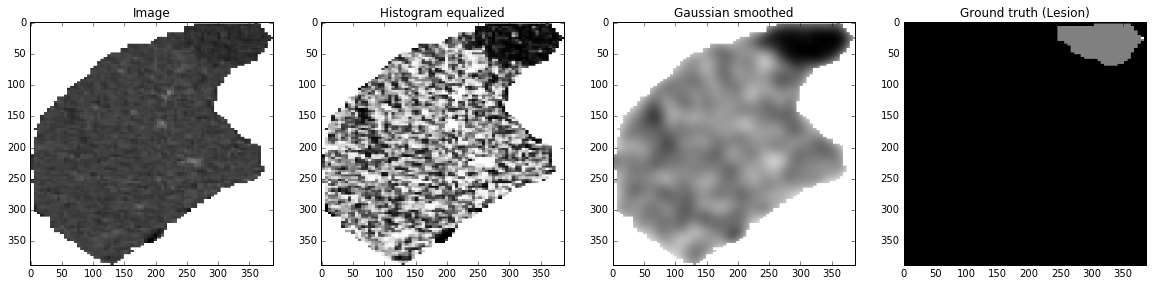

In [52]:
# Read img and crop mirrored edges
img,seg = read_imgs(dbimgit,dbsegit,1)
img=img[92:480,92:480]
bg=np.copy(img)==0

himg = histeq(img)


img[bg]=1
himg[bg]=255
gaus = np.array(Image.fromarray(himg).convert('L').filter(ImageFilter.GaussianBlur(radius=10)))
gaus[bg]=255
imshow(img,himg,gaus,seg, title=['Image','Histogram equalized','Gaussian smoothed','Ground truth (Lesion)'])


In [55]:
hist(seg)

'144016.000 , 6508.000 , 20.000, 0.000'